In [43]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd # pip install pandas
import seaborn as sns
import missingno as msno #para limpieza de datos
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [44]:
stars = pd.read_csv('Pulsar.csv')
#usamos head para visualizar
stars.head()

,Mean_Integrated,SD,EK,Skewness,Mean_DMSNR_Curve,SD_DMSNR_Curve,EK_DMSNR_Curve,Skewness_DMSNR_Curve,Class
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0


In [45]:
#limpieza de datos
stars.isna().sum() #Nan

Mean_Integrated         0
SD                      0
EK                      0
Skewness                0
Mean_DMSNR_Curve        0
SD_DMSNR_Curve          0
EK_DMSNR_Curve          0
Skewness_DMSNR_Curve    0
Class                   0
dtype: int64

<Axes: >

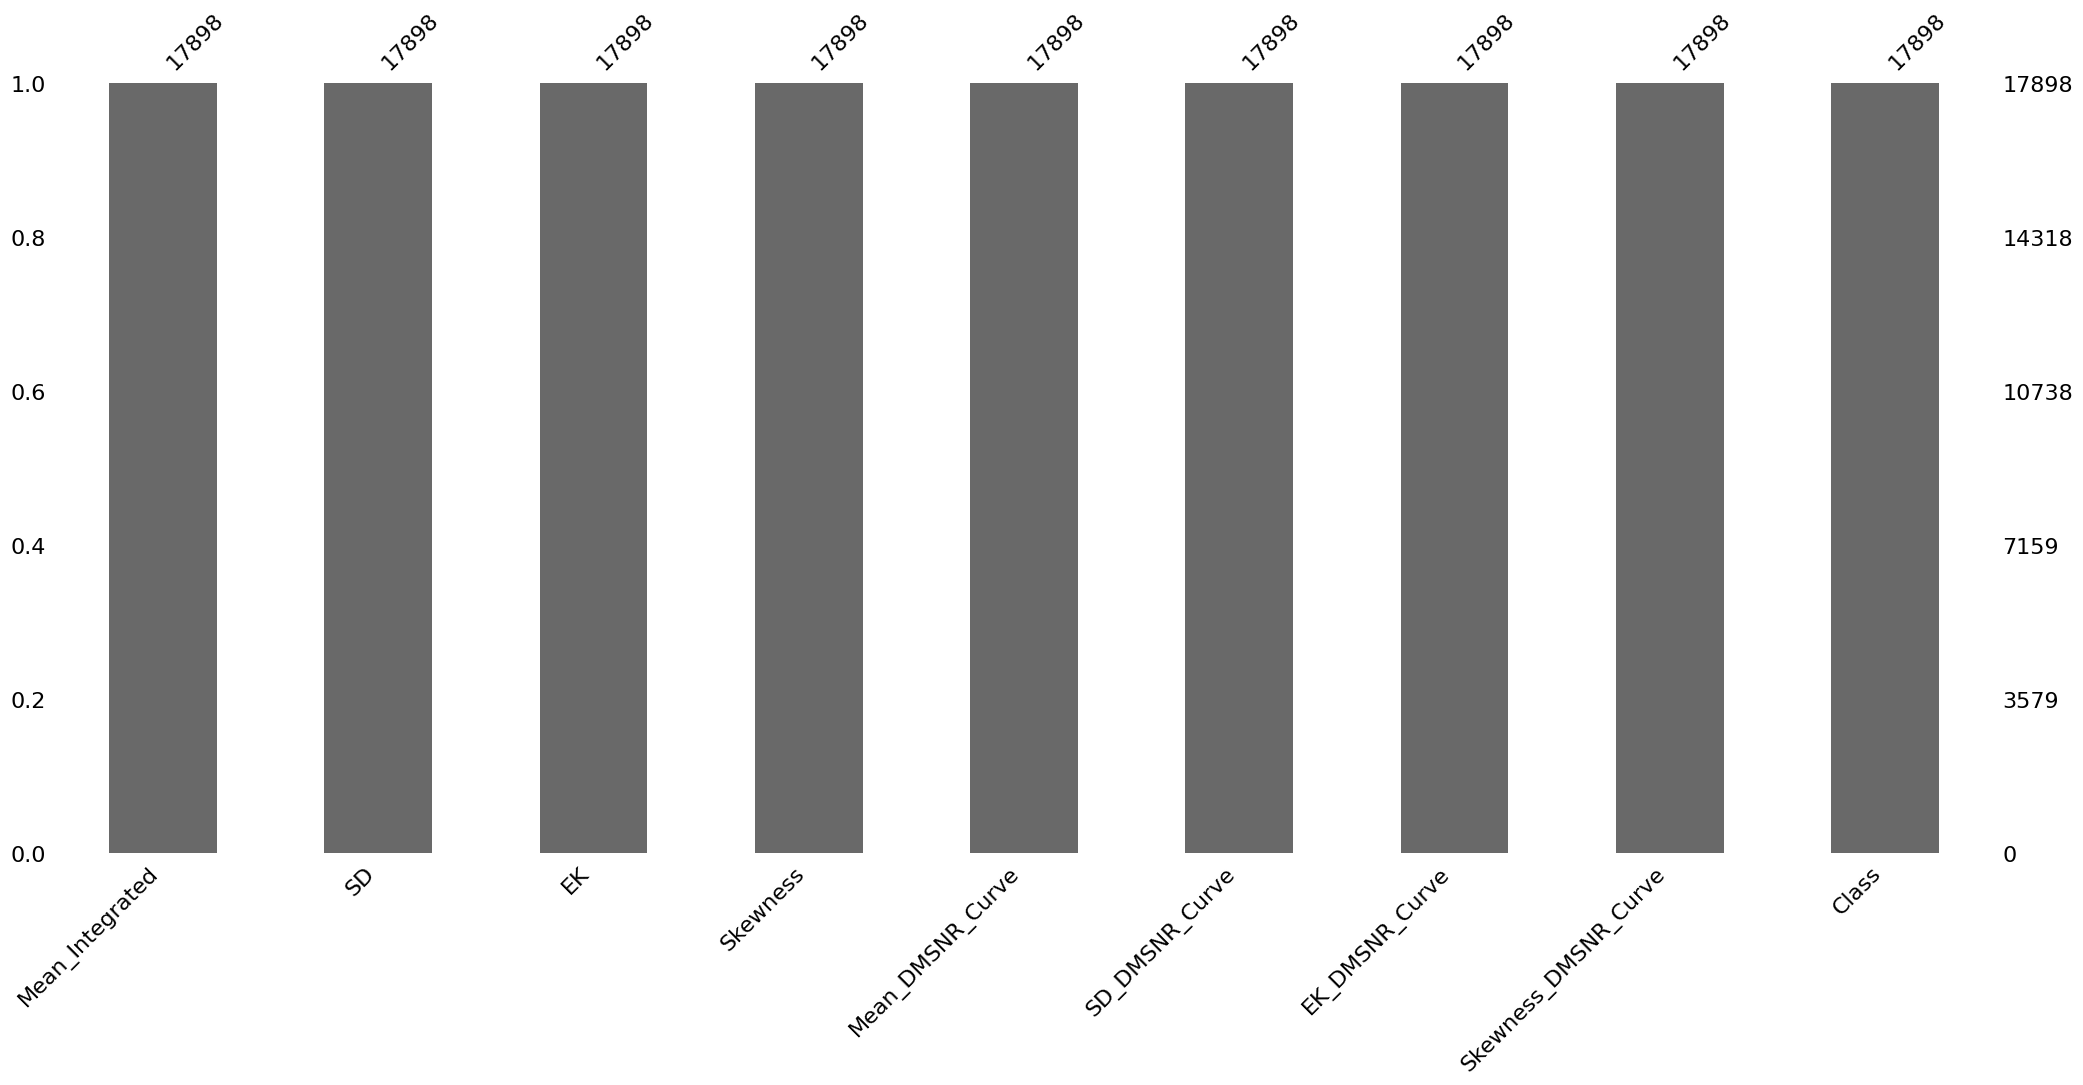

In [46]:
msno.bar(stars)

In [47]:
# Split the data into train and test
train_dataset = stars.sample(frac=0.8, random_state=0)
test_dataset = stars.drop(train_dataset.index)

print(stars.shape, train_dataset.shape, test_dataset.shape)
train_dataset.describe().transpose()

(17898, 9) (14318, 9) (3580, 9)


,count,mean,std,min,25%,50%,75%,max
Mean_Integrated,14318.0,111.076718,25.667571,5.812500,100.929688,115.105469,127.046875,190.421875
SD,14318.0,46.550077,6.822899,24.772042,42.407055,46.977559,51.036918,98.778911
EK,14318.0,0.478192,1.072770,-1.738021,0.026949,0.224016,0.473819,8.069522
Skewness,14318.0,1.784499,6.277860,-1.791886,-0.190602,0.196507,0.925124,68.101622
Mean_DMSNR_Curve,14318.0,12.727913,29.632155,0.213211,1.932483,2.798077,5.470318,222.421405
SD_DMSNR_Curve,14318.0,26.406667,19.549443,7.370432,14.457645,18.470136,28.481725,110.642211
EK_DMSNR_Curve,14318.0,8.289654,4.511528,-3.139270,5.774510,8.432818,10.675133,34.539844
Skewness_DMSNR_Curve,14318.0,104.582793,106.352681,-1.976976,34.786480,83.147625,138.329061,1191.000837
Class,14318.0,0.090166,0.286430,0.000000,0.000000,0.000000,0.000000,1.000000


In [48]:
# split features from labels
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('Class')
test_labels = test_features.pop('Class')

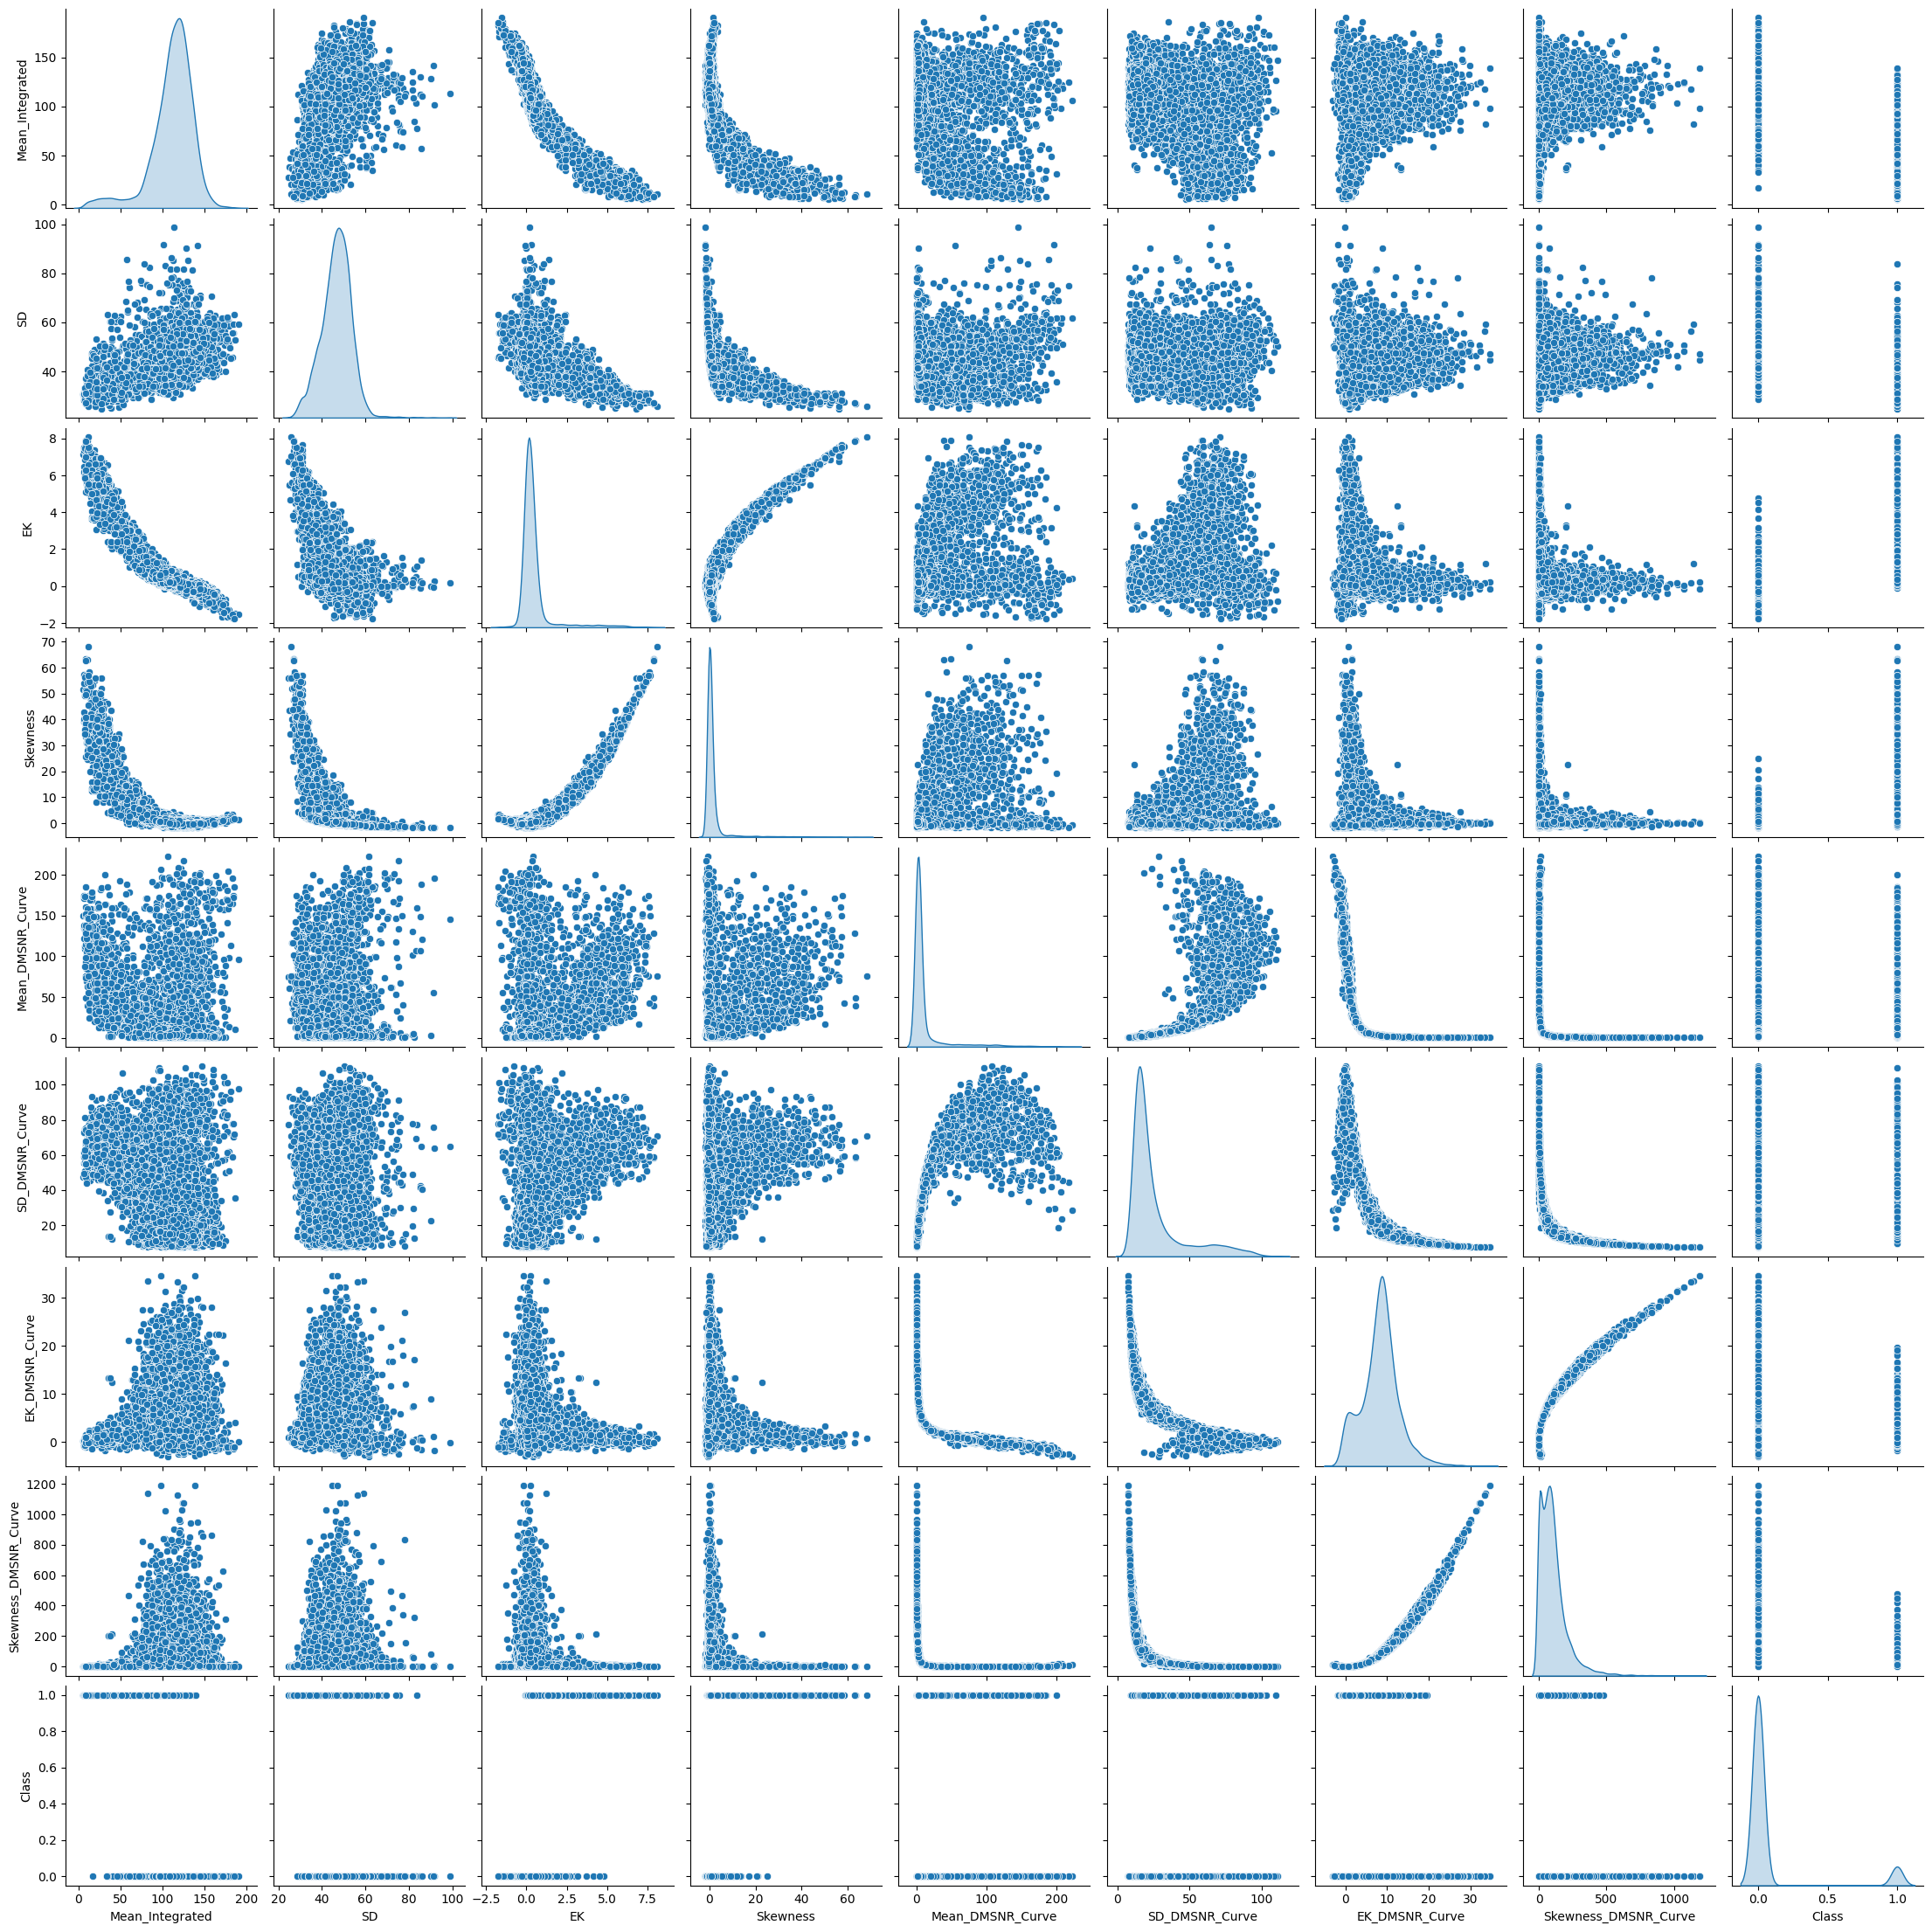

In [49]:
sns.pairplot(train_dataset[['Mean_Integrated','SD','EK','Skewness','Mean_DMSNR_Curve', 'SD_DMSNR_Curve','EK_DMSNR_Curve','Skewness_DMSNR_Curve','Class']], diag_kind='kde')

In [50]:
# Normalize
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())
print(normalizer.variance.numpy())

[[111.076706    46.550064     0.47819233   1.7844988   12.727917
   26.406658     8.289653   104.5828    ]]
[[6.5877777e+02 4.6548660e+01 1.1507543e+00 3.9408760e+01 8.7800250e+02
  3.8215384e+02 2.0352470e+01 1.1310100e+04]]


In [51]:
# Regression
 # 1. Normalize the input Mean_DMSNR_Curve
 # 2. Apply a linear transformation (y = m*x+b) to produce 1 output using layers.Dense

#feature = 'Mean_DMSNR_Curve'
features = np.array(train_features[['Mean_DMSNR_Curve','SD_DMSNR_Curve','EK_DMSNR_Curve','Skewness_DMSNR_Curve']])
print(features.shape, train_features.shape)

# Normalization
features_normalizer = layers.Normalization(input_shape=[4,], axis=None)

# adapt to the data
features_normalizer.adapt(features)

(14318, 4) (14318, 8)


In [61]:
# Sequential model
pulsar_model = keras.models.Sequential([
    features_normalizer,
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

pulsar_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_3 (Normalizat  (None, 4)                3         
 ion)                                                            
                                                                 
 dense_22 (Dense)            (None, 24)                120       
                                                                 
 dense_23 (Dense)            (None, 1)                 25        
                                                                 
Total params: 148
Trainable params: 145
Non-trainable params: 3
_________________________________________________________________


In [62]:
pulsar_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [63]:
%%time
history = pulsar_model.fit(
    train_features[['Mean_DMSNR_Curve','SD_DMSNR_Curve','EK_DMSNR_Curve','Skewness_DMSNR_Curve']],
    train_labels,
    epochs=30,
    # Suppress logging.
    verbose=2,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

Epoch 1/30
358/358 - 2s - loss: 0.2915 - accuracy: 0.9110 - val_loss: 0.2097 - val_accuracy: 0.9047 - 2s/epoch - 4ms/step
Epoch 2/30
358/358 - 1s - loss: 0.1952 - accuracy: 0.9077 - val_loss: 0.2034 - val_accuracy: 0.9026 - 631ms/epoch - 2ms/step
Epoch 3/30
358/358 - 1s - loss: 0.1920 - accuracy: 0.9123 - val_loss: 0.2023 - val_accuracy: 0.9064 - 640ms/epoch - 2ms/step
Epoch 4/30
358/358 - 1s - loss: 0.1908 - accuracy: 0.9129 - val_loss: 0.2012 - val_accuracy: 0.9106 - 630ms/epoch - 2ms/step
Epoch 5/30
358/358 - 1s - loss: 0.1894 - accuracy: 0.9125 - val_loss: 0.2013 - val_accuracy: 0.9099 - 845ms/epoch - 2ms/step
Epoch 6/30
358/358 - 1s - loss: 0.1881 - accuracy: 0.9159 - val_loss: 0.2004 - val_accuracy: 0.9113 - 979ms/epoch - 3ms/step
Epoch 7/30
358/358 - 1s - loss: 0.1867 - accuracy: 0.9157 - val_loss: 0.2002 - val_accuracy: 0.9120 - 1s/epoch - 3ms/step
Epoch 8/30
358/358 - 1s - loss: 0.1861 - accuracy: 0.9189 - val_loss: 0.1993 - val_accuracy: 0.9113 - 750ms/epoch - 2ms/step
Epoch 

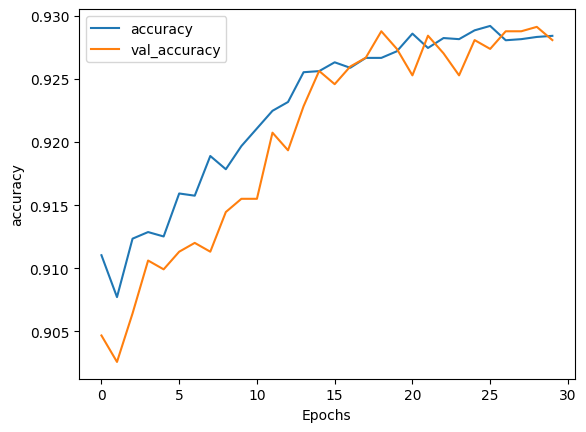

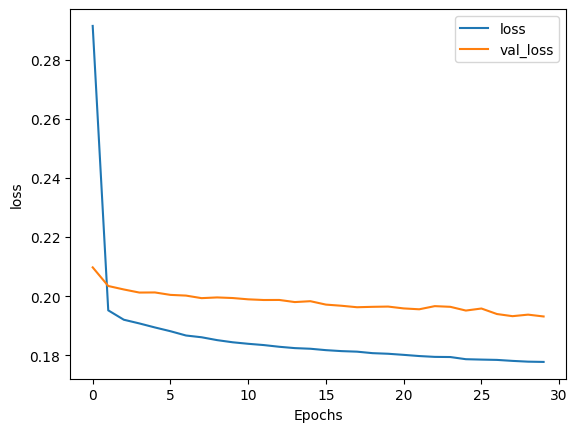

In [64]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [68]:
# Obtener las predicciones
#x_test = np.array([[41.5041806,62.89781076,1.472488674,1.305269046],[1.641304348,13.15851135,11.09366793,155.0446602]])
x_test = np.array([
    [41.5041806,62.89781076,1.472488674,1.305269046],
    [5.376254181,29.00989748,6.076265849,37.83139335],
    [1.641304348,13.15851135,11.09366793,155.0446602],
    [4.004180602,25.98402807,7.110256365,51.78034336],
    [125.264214,82.36350068,-0.141533847,-1.150789277]
    ])

predictions = pulsar_model.predict(x_test)

print(predictions)

1/1 [==============================] - 0s 49ms/step
[[0.56264937]
 [0.0496036 ]
 [0.00634932]
 [0.02918332]
 [0.4477096 ]]


In [70]:
pulsar_model.save('pulsar_model.h5')